# LDDMM Examples

In this file we run image matching LDDMM on several examples, and demonstrate the utilities in lddmm.py.

The only special functions LDDMM needs to run are

1. Interpolation
1. FFT
1. Gradient



## Library imports
We start by importing necessary libraries.  That includes numpy, matplotlib, and tensorflow for numerical work, nibabel for loading neuroimages, and lddmm and vis which are part of this library.

In [1]:
import numpy as np # for arrays
%matplotlib notebook
import matplotlib as mpl # for graphics
import matplotlib.pyplot as plt
import nibabel as nib # for loading neuroimages
import lddmm # algorithm
import vis # visualization
import tensorflow as tf

Importing helper functions
importing vis


## Development
During development, we have to reimport any libraries we are working on.

In [2]:
# for development
import imp
vis = imp.reload(vis)
lddmm = imp.reload(lddmm)

importing vis
Importing helper functions


## Example data
We will start with some human MRI as example data.  These are two atlases from mricloud.org.  We will deform the atlas to match the target.

In [3]:
# get filenames
atlas_image_fname = 'Adt27-55_02_Adt27-55_02_MNI.img'
target_image_fname = 'Adt27-55_03_Adt27-55_03_MNI.img'

In [4]:
# load them with nibabel
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [5]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing for atlas and target
if '.img' == atlas_image_fname[-4:]:    
    nx = img[0].header['dim'][1:4]
    dx = img[0].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
x = [np.arange(nxi)*dxi for nxi,dxi in zip(nx,dx)]


In [6]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]
# in this example, images are the same size
# this can be enfored after affine registration
# In the future, we can implement different sizes

<IPython.core.display.Javascript object>


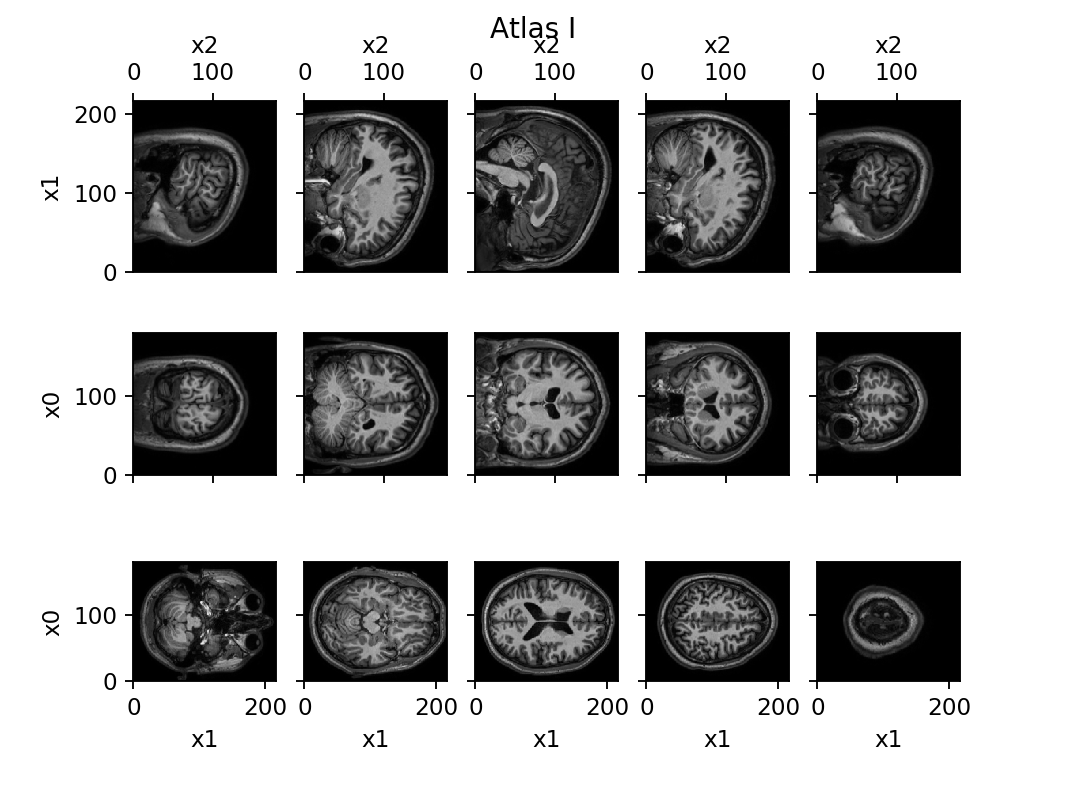

In [7]:
# display the data
f = plt.figure()
vis.imshow_slices(I,x=x,fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

<IPython.core.display.Javascript object>


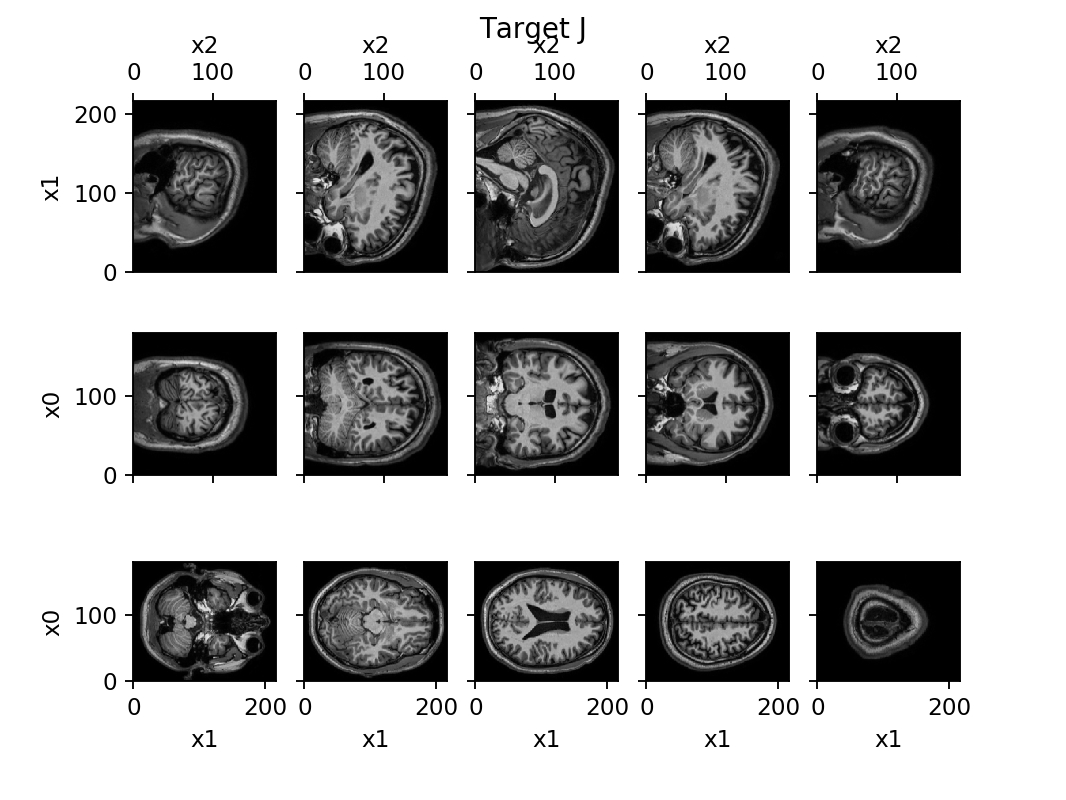

In [8]:
f = plt.figure()
vis.imshow_slices(J,x=x,fig=f)
f.suptitle('Target J')
f.canvas.draw()

## Interpolation
Deformations are compted by interpolating an image at a set of points.  We demonstrate interpolation here:

In [9]:
do_interp_test = False
if do_interp_test:
    # a quick test
    X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
    X0tf = tf.constant(X0,dtype=lddmm.dtype)
    X1tf = tf.constant(X1,dtype=lddmm.dtype)
    X2tf = tf.constant(X2,dtype=lddmm.dtype)
    Itf = tf.constant(I,dtype=lddmm.dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Id = lddmm.interp3(x[0],x[1],x[2],Itf,X0tf+10,X1tf*1.2,(X2tf/x[2][-1])**0.75*x[2][-1])
        Idnp = Id.eval()
    f = plt.figure()
    vis.imshow_slices(Idnp,x=x,fig=f)
    f.suptitle('Example of transforming by interpolation')
    f.canvas.draw()
    

## Gradient
Gradients are required to know how the energy will change when the image moves a small amount.  We demonstrate this here

In [10]:
do_grad_test = False
if do_grad_test:
    # a quick test    
    Itf = tf.constant(I,dtype=lddmm.dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        I_0,I_1,I_2 = lddmm.grad3(Itf,dx)
        Ishow = tf.sqrt(I_0**2 + I_1**2 + I_2**2)
        Ishownp = Ishow.eval()
    f = plt.figure()        
    vis.imshow_slices(Ishownp,x=x,fig=f)
    f.canvas.draw()
    

## LDDMM

Importing helper functions
Set default parameters
Got parameters


<IPython.core.display.Javascript object>


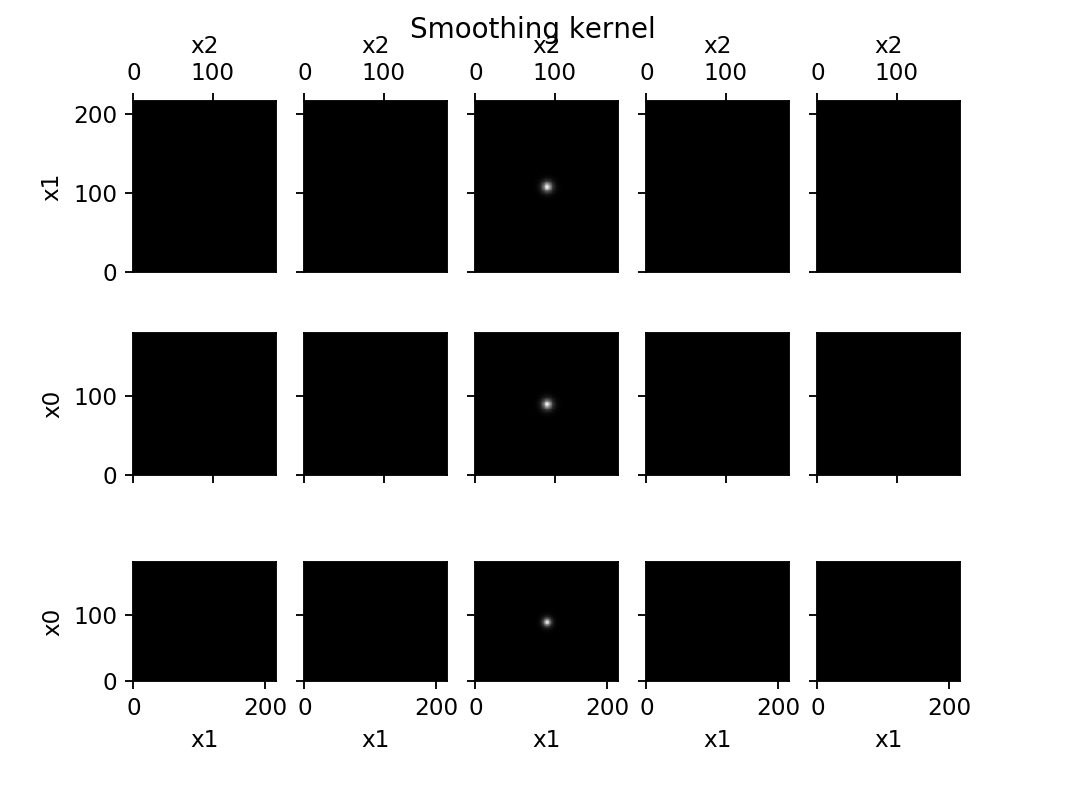

Built energy operators
built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


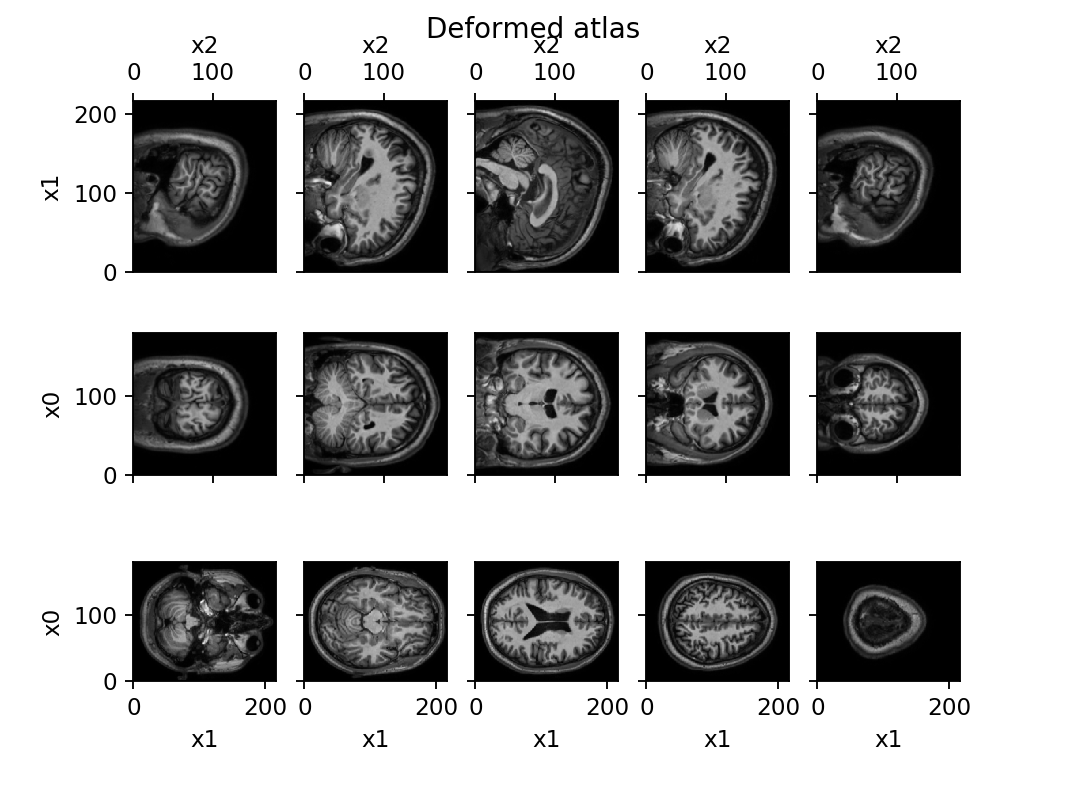

<IPython.core.display.Javascript object>


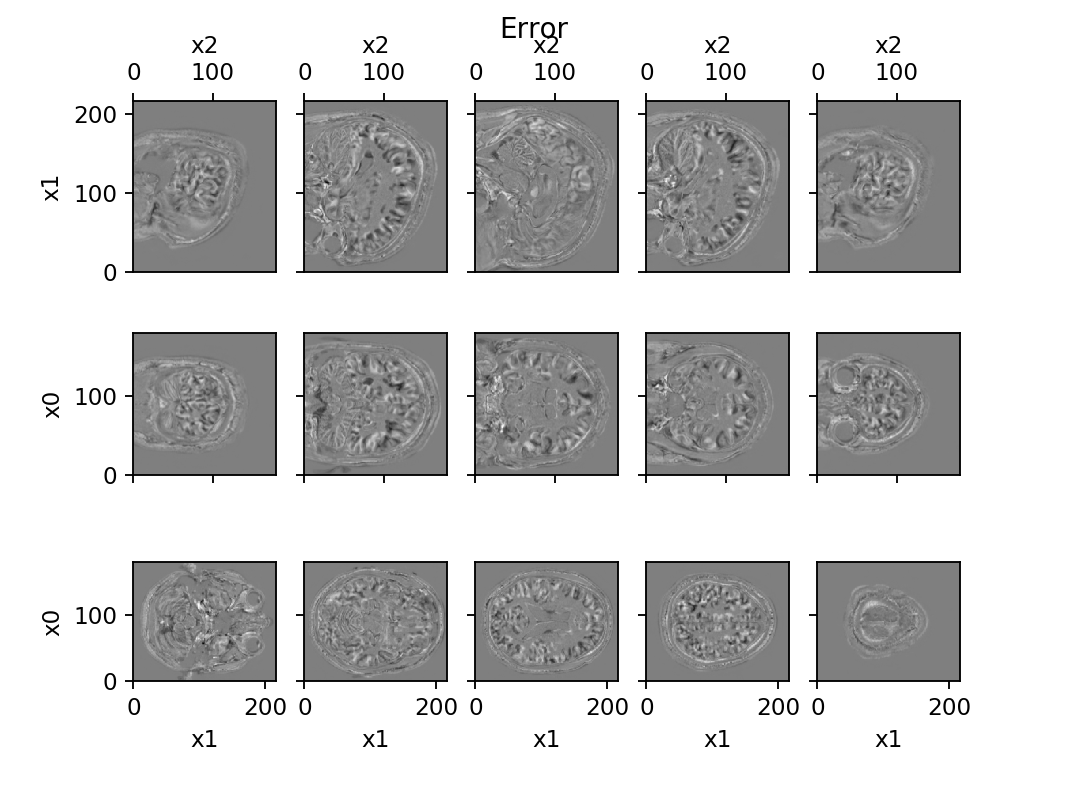

<IPython.core.display.Javascript object>


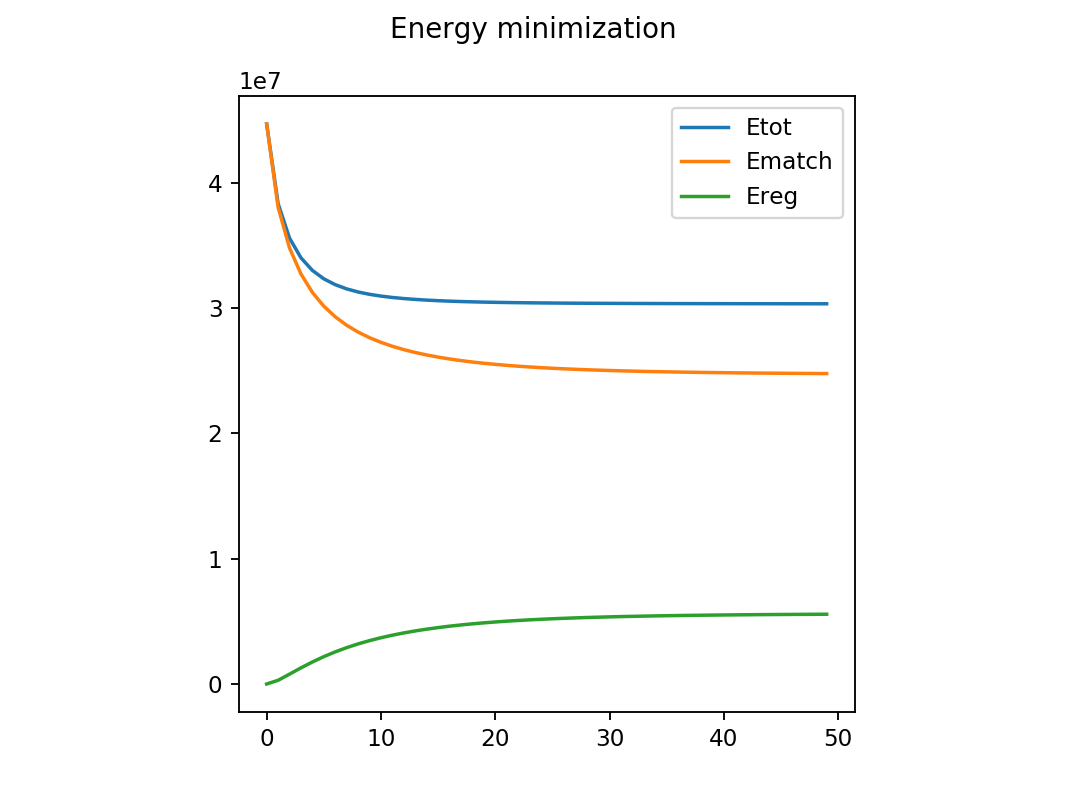

Finished iteration 0, energy 44694201.17675823 (match 44694201.17675823, reg 0.0)
Finished iteration 1, energy 38341210.265246004 (match 38045386.4802176, reg 295823.7850284073)
Finished iteration 2, energy 35587109.399160214 (match 34800327.9076039, reg 786781.4915563165)
Finished iteration 3, energy 34014111.925903164 (match 32727363.867947318, reg 1286748.0579558488)
Finished iteration 4, energy 33008876.01875095 (match 31252705.652180653, reg 1756170.3665702988)
Finished iteration 5, energy 32337633.791035518 (match 30154599.92661704, reg 2183033.8644184787)
Finished iteration 6, energy 31870944.43016883 (match 29306750.665474944, reg 2564193.7646938846)
Finished iteration 7, energy 31534646.17759179 (match 28633006.7562362, reg 2901639.4213555893)
Finished iteration 8, energy 31286844.567150865 (match 28087635.655530438, reg 3199208.9116204283)
Finished iteration 9, energy 31100996.997864712 (match 27639658.698081557, reg 3461338.2997831553)
Finished iteration 12, energy 30762932.

In [11]:
lddmm = imp.reload(lddmm)
out = lddmm.lddmm(I,J,niter=50,sigmaM=1e1,sigmaR=1e0,epsilon=1e-1,p=2,a=2)

## Example with mouse images


In [12]:
# get filenames
atlas_image_fname = 'PMD2052_orig_target_STS_clean.img'
target_image_fname = 'PMD3097_orig_target_STS_clean.img'

In [13]:
# load them with nababel
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [14]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing for atlas and target
if '.img' == atlas_image_fname[-4:]:    
    nx = img[0].header['dim'][1:4]
    dx = img[0].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
x = [np.arange(nxi)*dxi for nxi,dxi in zip(nx,dx)]


In [15]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]
# in this example, images are the same size
# this can be enfored after affine registration
# In the future, we can implement different sizes

<IPython.core.display.Javascript object>


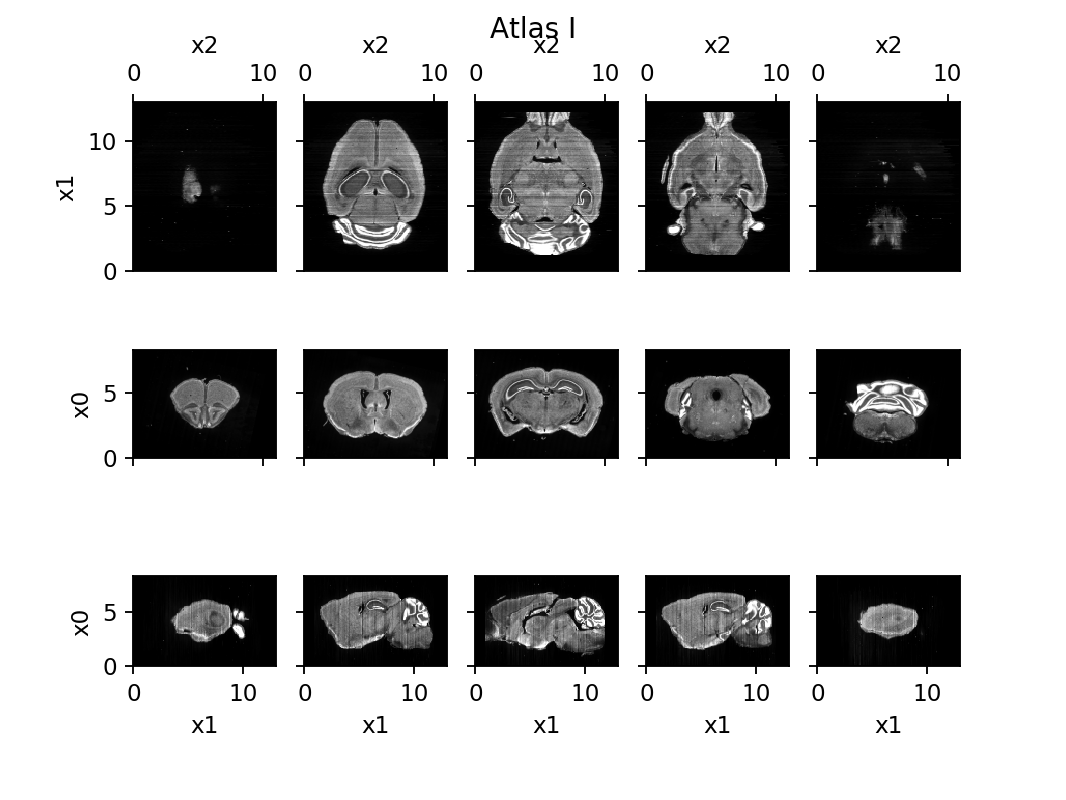

In [16]:
# display the data
f = plt.figure()
vis.imshow_slices(I,x=x,fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

<IPython.core.display.Javascript object>


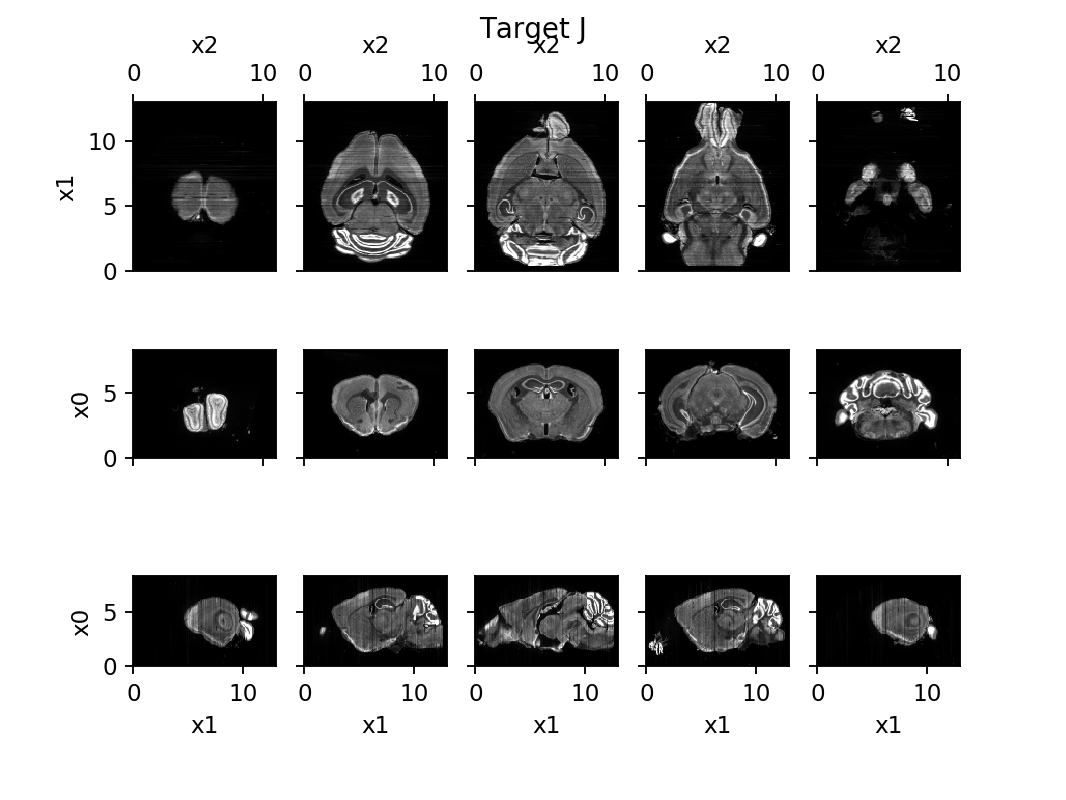

In [17]:
f = plt.figure()
vis.imshow_slices(J,x=x,fig=f)
f.suptitle('Target J')
f.canvas.draw()

Importing helper functions
Set default parameters
Got parameters


<IPython.core.display.Javascript object>


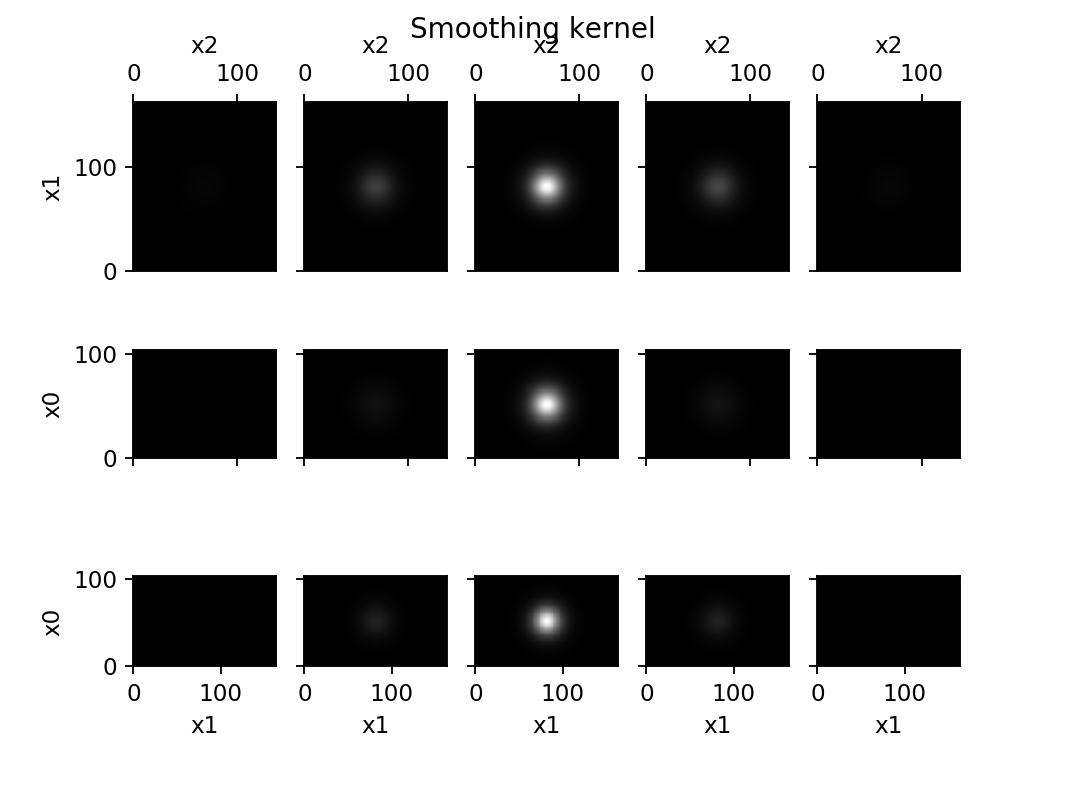

Built energy operators
built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


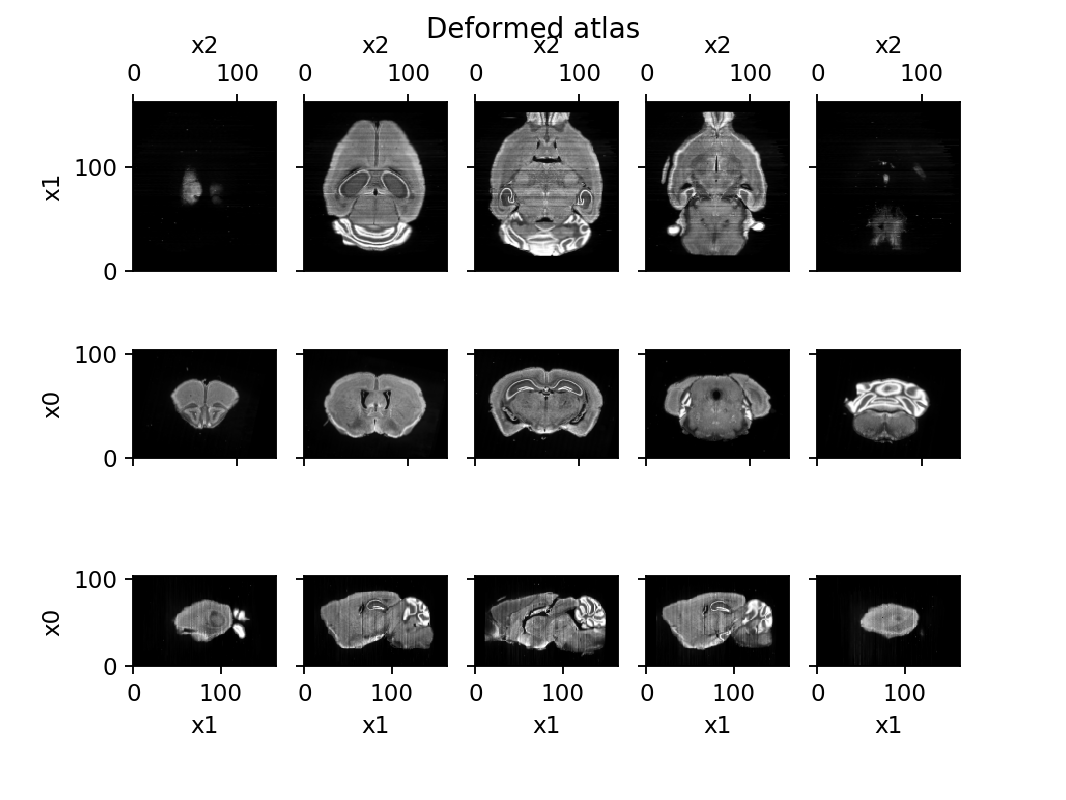

<IPython.core.display.Javascript object>


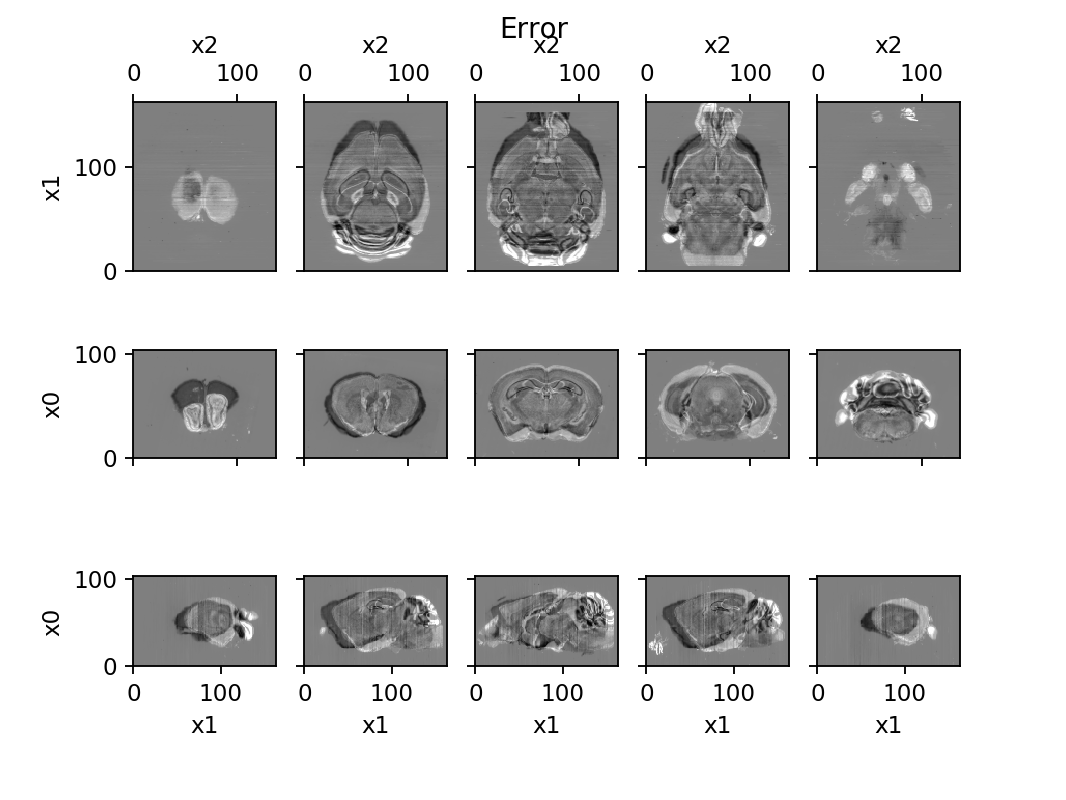

<IPython.core.display.Javascript object>


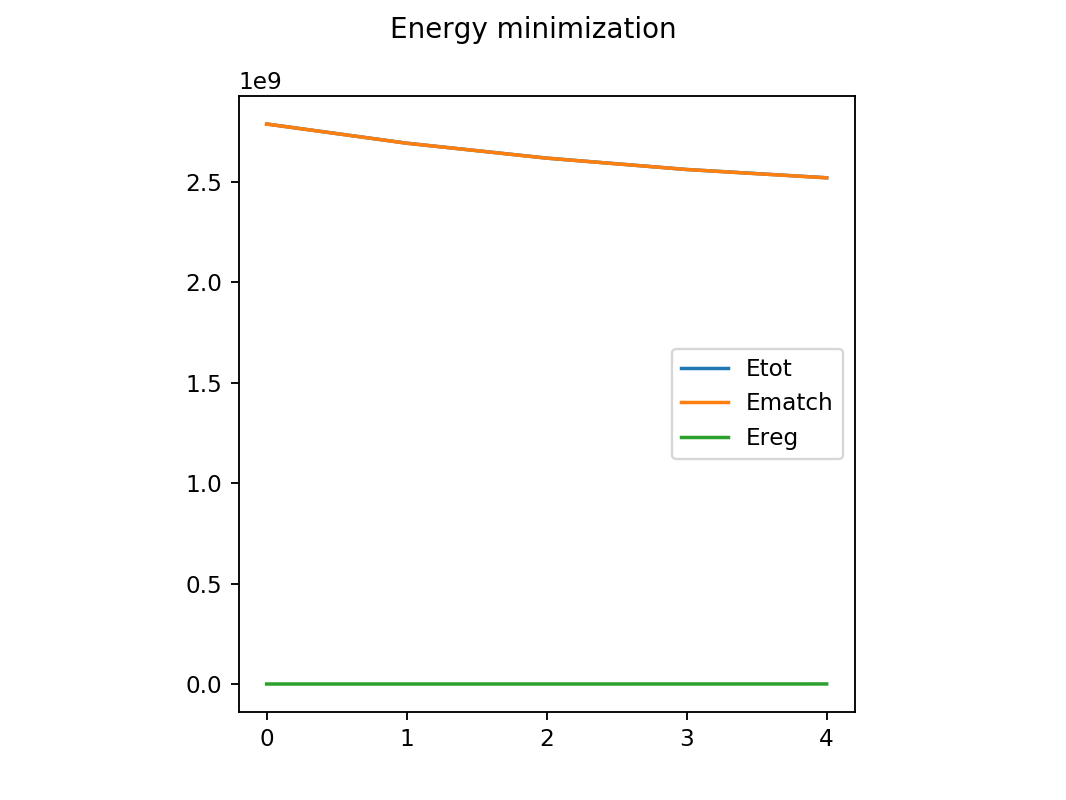

Finished iteration 0, energy 2789521735.843161 (match 2789521735.843161, reg 0.0)
Finished iteration 1, energy 2693915196.09544 (match 2693896310.124324, reg 18885.97111625429)
Finished iteration 2, energy 2619549241.353031 (match 2619474809.840891, reg 74431.51214009208)
Finished iteration 3, energy 2562954180.9062757 (match 2562789547.4357834, reg 164633.47049251862)
Finished iteration 4, energy 2521715675.676439 (match 2521427653.073391, reg 288022.6030480041)


In [18]:
lddmm = imp.reload(lddmm)
out = lddmm.lddmm(I, J, niter=5, epsilon=1e-3)

Test markdown

| | |
|---|---|
|<img src="human_mri_example_atlas.png" alt="Human MRI atlas" width="256"/>  |  <img src="human_mri_example_target.png" alt="Human MRI target" width="256"/>|

